In [1]:
!pip install --upgrade pip
from pip import main
#main(['install', 'pyspark==2.4.5'])
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
sc = SparkContext(conf=SparkConf())
spark = SparkSession(sc)

Requirement already up-to-date: pip in c:\users\riley\anaconda3\lib\site-packages (20.0.2)


In [905]:
import wget
url = 'https://raw.githubusercontent.com/ngc4254/ADSCap/master/CombineStats.csv' #NEED TO UPDATE PER DATA SET
filename = wget.download(url)
print(filename)

100% [..............................................................................] 40927 / 40927CombineStats (2).csv


In [906]:
#LOAD DATA INTO DATAFRAME
df_name ='df_combine' #NEED TO UPDATE PER DATASET
df = spark.read.csv('CombineStats.csv',header='True',inferSchema='True') #NEED TO UPDATE PER DATA SET
df.createOrReplaceTempView(df_name)

#Rename columns to use underscores instead of spaces
from pyspark.sql.functions import col
from pyspark.sql.functions import *
df_rc = [col(column).alias(column.replace(' ', '_')) for column in df.columns]
df_sql = df.select(*df_rc)

#Add index to make joins easier later on
df_sql = df_sql.withColumn("id", monotonically_increasing_id())
df_sql.createOrReplaceTempView('mainTable')
#df_sql.show()

In [907]:
#Select position & draft class to be analyzed
pos='WR' #MANUAL INPUT
draft_class = '2020' #MANUAL INPUT
#Create dataframe containing data to be classified
df_2class = spark.sql('select * from mainTable where fantpos=\'' + pos + '\' and draft_year=' + draft_class)
#df_2class.show()

In [908]:
#CREATE PLAYER LOOKUP TABLE
#NOTE THIS COULD CAUSE PROBLEMS LATER ON IF 2 PLAYERS HAVE SAME NAME AND SAME POS
df_id = spark.sql('select distinct player, fantpos, id from mainTable') 
df_id.createOrReplaceTempView('Id')
#df_newid = spark.sql('select distinct player, fantpos, id from main2Table') 
#df_newid.createOrReplaceTempView('newId')
#df_id.show()

In [909]:
#CREATE A DATA FRAME OF PLAYERS FROM OTHER DRAFT CLASSEST THAT HAVE BEEN CLASSIFIED
#NOTE THAT RAW DATA HAS ALREADY BEEN CLASSIFIED. EACH PLAYER HAS BEEN ASSIGNED A VALUE OF 1-10 BASED ON CAREER FANTASY PRODUCTION
df_classified = spark.sql('select * from mainTable where fantpos=\'' + pos + '\' and clust is not null and draft_year<' + draft_class)
#df_classified.show()

In [910]:
#CLEANING STEP - SET COLUMN DATA TYPES
#df_classified.dtypes
df_classified = df_classified.select(df_classified.espn_rank.cast("int"),df_classified.height.cast("int"),df_classified.weight.cast("int"),df_classified.armlength.cast("float"),df_classified.handsize.cast("float"),df_classified.forty.cast("float"),df_classified.ten_split.cast("float"),df_classified.bench.cast("int"),df_classified.vertical.cast("float"),df_classified.broad.cast("int"),df_classified.shuttle.cast("float"),df_classified.cone.cast("float"),df_classified.clust.cast("int"),df_classified.id.cast("int"),df_2class.draft_year.cast("int"))
#df_classified.show()
df_2class = df_2class.select(df_2class.espn_rank.cast("int"),df_2class.height.cast("int"),df_2class.weight.cast("int"),df_2class.armlength.cast("float"),df_2class.handsize.cast("float"),df_2class.forty.cast("float"),df_2class.ten_split.cast("float"),df_2class.bench.cast("int"),df_2class.vertical.cast("float"),df_2class.broad.cast("int"),df_2class.shuttle.cast("float"),df_2class.cone.cast("float"),df_2class.clust.cast("int"),df_2class.id.cast("int"),df_2class.draft_year.cast("int"))
#df_2class.show()
df_classified.createOrReplaceTempView('mainTable')
df_2class.createOrReplaceTempView('main2Table')

In [911]:
#Normalize data
#Union together otherwise each df would need to be normalized on its own
df_norm_full = df_classified.union(df_2class)
df_norm_full.createOrReplaceTempView('fullTable')
#NORMALIZE VALUE = VALUE - MIN(VALUE)/ (MAX(VALUE) - MIN(VALUE))
#OPEN TO NORMALIZE IN OTHER WAYS, BUT THIS IS A SIMPLE WAY THAT ENSURE EACH COLUMN VARIES FROM 0 TO 1
#ALSO NICE BECAUSE REPEATEDLY RUNNING THIS NORMALIZATION WILL NOT CHANGE RESULTS. VALUES WILL STAY THE SAME AFTER 1ST NORMALIZATION
#FUNCTION TO NORMALIZE
def normalize_feature(feature, df, table):
    if "norm_" + feature in df.columns:
        df = df.drop("norm_" + feature)
    df1 = spark.sql("SELECT a.id , (a." + feature + " - b.minval)/(b.maxval - b.minval) as norm_" + feature + " from " + table + " a inner join (select min(" + feature + ") as minval, max(" + feature + ") as maxval from " + table + ") b on a." + feature + ">=b.minval-1")
    df = df.join(df1, ["id"]).withColumn(feature, col("norm_" + feature))
    df = df.drop("norm_" + feature)
    return df
#CALL FUNCTION FOR EACH FEATURE
print ('These columns have been normalized:')
for i in df_classified.columns[:-3]:
    print(i)
    df_norm_full = normalize_feature(i, df_norm_full, 'fullTable')
df_norm_full.createOrReplaceTempView('fullTable')

flip = 'N' #MANUAL INPUT SET TO Y TO TRIGGER FLIPPING BELOW
#Flip any features where a lower score is better so that all features can be interpreted as 0=worst and 1=best
#In this case: forty, ten_split, shuttle, cone
if flip = 'Y': 
    import pandas as pd
    df_norm_full = df_norm_full.toPandas()
    df_norm_full['forty'] = 1 - df_norm_full['forty']
    df_norm_full['ten_split'] = 1 - df_norm_full['ten_split']
    df_norm_full['shuttle'] = 1 - df_norm_full['shuttle']
    df_norm_full['cone'] = 1 - df_norm_full['cone']
    df_norm_full = spark.createDataFrame(df_norm_full)
    df_norm_full.createOrReplaceTempView('fullTable')

These columns have been normalized:
espn_rank
height
weight
armlength
handsize
forty
ten_split
bench
vertical
broad
shuttle
cone


In [912]:
#Split data back into same group used in classified and 2class dataframes
df_norm2 = spark.sql('select * from fullTable where draft_year=' + draft_class)
df_norm2.createOrReplaceTempView('norm2Table')
df_norm = spark.sql('select * from fullTable where draft_year<' + draft_class)
df_norm.createOrReplaceTempView('normTable')

#cleanup unnecessary stuff
spark.catalog.dropTempView('fullTable')
df_norm2 = df_norm2.drop('draft_year')
df_norm = df_norm.drop('draft_year')

In [913]:
#Function to create a correlation matrix
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics
def gen_corr_mtx(df, input_cols, output_col):
    assembler = VectorAssembler(inputCols=input_cols, outputCol= output_col)
    df_vect = assembler.transform(df).select(output_col)
    corr_mtx = Correlation.corr(df_vect, output_col)
    corr_mtx = corr_mtx.collect()[0]["pearson(Corrs)".format(df_vect)].values
    corr_mtx = sc.parallelize(corr_mtx.reshape(-1, len(input_cols)))
    corr_mtx = Statistics.corr(corr_mtx)
    return corr_mtx

In [914]:
#Remove any columns from consideration if their absolute correlation with 'Clust' is less than a certain amount
#Currently seeting bar for minimum correlation at mean/2.5 but that can be configured as desired
corr_w_clust = []
cols = []
for i in df_norm.columns[1:-1]:
    #print(i)
    corr_1 = df_norm.stat.corr(i,'clust')
    corr_w_clust.append(corr_1)
    cols.append(i)
corr_w_clust = np.asarray(corr_w_clust, dtype=np.float32)
cols = np.asarray(cols)
cols = cols[np.where(np.abs(corr_w_clust)>np.mean(np.abs(corr_w_clust))/2.5)] #ADJUST THIS FORMULA SO THE DESIRED NUMBER OF COLUMNS ARE IN RESULT
cols = cols[np.where(cols!='ten_split')] #I remove forty or ten_split because of high correlation. Currently using forty but would prefer ten_split because past analysis has shown it to be a better predictor of nfl success, but data in here seems unreliable
#This could cause problems if ten_split is removed due to lack of correlation with clust, but forty is not
#if pos=='WR':
#    cols = cols[np.where(cols!='bench')] #I remove bench for WRs because of how few performed the drill
print(cols)

['espn_rank' 'height' 'weight' 'armlength' 'handsize' 'forty' 'bench']


In [915]:
#Reduce DF_NORM and DF_NORM2 to columns selected above
select = 'select id, '
for i in cols:
    select = select + str(i) + ', '
df_norm_red = spark.sql(select + ' clust from normTable')
df_norm2_red = spark.sql(select + ' clust from norm2Table')

In [916]:
#I get correlation matrix after normalizing but you could get the same result doing it before
corr_mtx_normed = gen_corr_mtx(df_norm_red.union(df_norm2_red), cols,'Corrs') #IGNORES FIRST AND LAST COLUMN BECAUSE THEY AREN'T FEATURES
#print(corr_mtx_normed)

In [917]:
import numpy as np
feature_selection = np.empty([1,1])
#Returns list of features with less than the specified abs(corr coeff) as well as the measurement column
def select_features(corr_mtx, df,measure,max_corr_coeff):
    col_num = corr_mtx.shape[0]
    mask = np.full((col_num,), True, dtype=bool)
    for i in range(col_num):
        for j in range(i+1, col_num):
            if corr_mtx[i,j] >= max_corr_coeff:# or corr_mtx[i,j] <= -1 * max_corr_coeff:
                if mask[j]:
                    mask[j] = False
    feature_selection = np.array(df.columns[1:-1])[mask]
    #This step just add the measurement column back in.
    if measure not in feature_selection:
        all_columns = np.append(feature_selection,measure)
        all_columns = np.append(all_columns,'id')
    return feature_selection, all_columns

#THIS IS WHERE YOU SPECIFY CORR MATRIX, MEASUREMENT COL, MAXIMUM ALLOWABLE CORRELATEION COEFF
#RECOMMEND TWEAKING MAX COEFF PARAMETER TO PRODUCE NO FEWER THAN 3 FEATURES. THIS COULD BE PROGRAMMED SO THAT INPUT IT DESIRED # OF FEATURES
feature_selection, all_columns = select_features(corr_mtx_normed,df_norm_red.union(df_norm2_red),'clust',0.3) #MANUAL INPUT (LAST NUMBER ONLY)
print('The features that will be included in regression are: ' + str(feature_selection))
print('The remaining columns in the dataframe are: ' + str(all_columns))

The features that will be included in regression are: ['espn_rank' 'height' 'forty' 'bench']
The remaining columns in the dataframe are: ['espn_rank' 'height' 'forty' 'bench' 'clust' 'id']


In [918]:
#Create dataframes without rows that failed feature selection test
select_cols = 'select '
for i in all_columns:
    select_cols = select_cols + str(i) + ', '
df_comp = spark.sql(select_cols[:-2] + ' from normTable')
df_comp2 = spark.sql(select_cols[:-2] + ' from norm2Table a')
select_cols = 'select '
for i in feature_selection:
    select_cols = select_cols + str(i) + ', '
df_feat = spark.sql(select_cols[:-2] + ' from normTable')
df_feat2 = spark.sql(select_cols[:-2] + ' from norm2Table a')

In [919]:
#Create a single dataframe will all the data to allow new and old to be clustered together
df_all = df_feat.union(df_feat2)
#df_all.count()

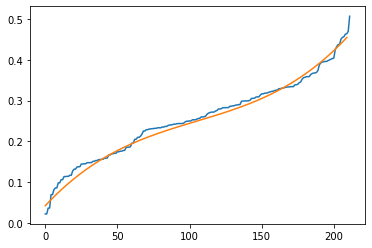

In [963]:
#Step for DBSCAN to cluster players based on remaining features.
#PARAMETER TUNING (EPS & MIN_SAMPLES) SHOULD BE AUTOMATED BUT BELOW IS CURRENTLY MANUAL

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize
import pandas as pd
import matplotlib.pyplot as plt
#import multipolyfit as mpf

df_clust = df_all.toPandas()
df_clust = StandardScaler().fit_transform(df_clust)
df_clust = normalize(df_clust) #Do I want this?
df_clust = pd.DataFrame(df_clust)

distances, indices = NearestNeighbors(n_neighbors=2).fit(df_clust).kneighbors(df_clust)
y = np.sort(distances,axis=0)[:,1]
x = np.sort(indices,axis=0)[:,1]
plt.plot(y)

#Create
degrees=3 #MANUAL INPUT. DETERMINE BASED ON PLT.PLOT(Y)
z=np.polyfit(x, y, degrees)
x_smooth = np.arange(np.min(x)-1, np.max(x)+1, 1)
y_smooth = np.polyval(z, x_smooth)
plt.plot(y_smooth)

In [988]:
ydif = np.diff(y_smooth)
ydif2 = np.diff(y_smooth,n=2)
cur = (1 + ydif**2)**1.5
cur = ydif2/cur[1:]
#ydif = np.where(np.isnan(ydif),-999,ydif)
#ydif = np.where(np.isinf(ydif),-999,ydif)
eps = y_smooth[np.where(cur==np.amax(cur))][0]
#Scale eps down slightly, ir gives much better results
eps = 0.99*eps #trying to approximate logic from https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
#eps = eps-0.01
print(eps)

0.43729643846458793


In [989]:
#Maunal optimization notes.. 
#corr_coeff eps num_samples dist([])
#.65 .49 6 ([23, 94,  4, 46,  4,  5,  4]))
#.65 .425 4 ([28, 76, 52,  5,  5,  5,  9]))
#df_dbscan = DBSCAN(eps = 0.4056, min_samples = 4).fit(df_clust) #use these values if features are espn_rank, height, ten_split, bench
#df_dbscan = DBSCAN(eps = 0.26, min_samples = 4, metric='euclidean').fit(df_clust) #use these values for features espn_rank, height, ten_split
df_dbscan = DBSCAN(eps = eps, min_samples = 4, metric='euclidean').fit(df_clust) 
#df_dbscan = DBSCAN(eps = 0.43, min_samples = 4, metric='euclidean').fit(df_clust)
labels = df_dbscan.labels_
print(np.unique(labels, return_counts=True))

(array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64), array([20, 67, 39,  9, 64,  4,  5,  4], dtype=int64))


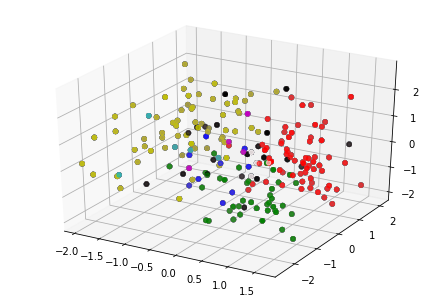

In [990]:
#CREATE SCATTER PLOT
#CURRENT SET UP INCLUDES MAX OF 16 COLOURS OR 16 LABELS FROM PREVIOUS RESULT

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib._color_data as mcd
%matplotlib inline

#SETTING TO 3D FOR THIS CASE SINCE THERE ARE 3 FEATURES. SHOULD BE MORE GENERAL
fig = plt.figure()
ax = Axes3D(fig)

#NEED TO IMPORT MORE COLOURS
colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[3] = 'y'
colours[4] = 'w'
colours[5] = 'c'
colours[6] = 'm'
colours[7] = mcd.CSS4_COLORS['aqua']
colours[8] = mcd.CSS4_COLORS['beige']
colours[9] = mcd.CSS4_COLORS['pink']
colours[10] = mcd.CSS4_COLORS['purple']
colours[11] = mcd.CSS4_COLORS['lime']
colours[12] = mcd.CSS4_COLORS['darkblue']
colours[13] = mcd.CSS4_COLORS['brown']
colours[14] = mcd.CSS4_COLORS['silver']
colours[-1] = 'k'
  
cvec = [colours[label] for label in labels]


k = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[-1])
r = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[0]) 
g = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[1]) 
b = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[2]) 
y = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[3])
w = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[4]) 
c = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[5]) 
m = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[6])  
aqua = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[7]) 
beige = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[8]) 
pink = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[9])
purple = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[10])
lime = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[11])
darkblue = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[12])
brown = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[13])
silver = ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], marker ='o', color = colours[14])

#plt.figure(figsize =(9, 9)) 
ax.scatter(df_scal[df_scal.columns[0]], df_scal[df_scal.columns[1]], df_scal[df_scal.columns[2]], c = cvec)
plt.show()

In [991]:
#Add new classification value to data
df_all = df_feat.union(df_feat2)
df_all = df_all.toPandas()
df_all['class'] = cvec
df_all = spark.createDataFrame(df_all)

In [992]:
#Create string for join conditions
join_cons_ab = ''
join_cons_ac = ''
for i in df_feat.columns:
    print(i)
    join_cons_ab = join_cons_ab + ' a.' + i + '=b.' + i + ' and'
    join_cons_ac = join_cons_ac + ' a.' + i + '=c.' + i + ' and'
join_cons_ab = join_cons_ab[:-3]
join_cons_ac = join_cons_ac[:-3]

espn_rank
height
forty
bench


In [993]:
#Create Train and Test datasets
#Should really split df_train into train and test using train_test_split, but doing it this way because of small sample size
#Could see problems if there are multiple players with the exact same values in all feature columns
df_all.createOrReplaceTempView('all_data')
df_comp2.createOrReplaceTempView('new_data')
df_comp.createOrReplaceTempView('old_data')
df_train = spark.sql("SELECT a.*, c.id from all_data a left join new_data b on " + join_cons_ab + " inner join old_data c on " + join_cons_ac + " where b.id is null")
print(df_train.count())
df_test = spark.sql("SELECT a.*, b.id from all_data a inner join new_data b on " + join_cons_ab)
print(df_test.count())

180
32


In [994]:
#Create pipelines for several types of regression so user has option
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer
Reg_Type='Random Forest' #MANUAL INPUT, SPECIFY DESIRED REGRESSION TYPE HERE
if Reg_Type =='Linear':
    from pyspark.ml.regression import LinearRegression
    indexer = StringIndexer(inputCol='class', outputCol='label')
    vectorAssembler = VectorAssembler(inputCols=df_train.columns[:-2], outputCol='features')
    #normalizer = Normalizer(inputCol='features', outputCol = 'features_norm', p=1.0)
    lir = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
    pipeline = Pipeline(stages=[indexer, vectorAssembler, lir])
    print('linear regression selected')

if Reg_Type == 'Logistic':
    from pyspark.ml.classification import LogisticRegression
    indexer = StringIndexer(inputCol='class', outputCol='label')
    vectorAssembler = VectorAssembler(inputCols=df_train.columns[:-2], outputCol='features')
    lor = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
    pipeline = Pipeline(stages=[indexer, vectorAssembler, lor])
    print ('logistic regression selected')

if Reg_Type == 'Random Forest':
    from pyspark.ml.regression import RandomForestRegressor
    indexer = StringIndexer(inputCol='class', outputCol='label')
    vectorAssembler = VectorAssembler(inputCols=df_train.columns[:-2], outputCol='features')
    rf = RandomForestRegressor(featuresCol="features")
    pipeline = Pipeline(stages=[indexer, vectorAssembler, rf])
    print ('random forest regression selected')
    
if Reg_Type == 'Naive Bayes':
    from pyspark.ml.classification import NaiveBayes
    indexer = StringIndexer(inputCol='class', outputCol='label')
    vectorAssembler = VectorAssembler(inputCols=df_train.columns[:-2], outputCol='features')
    nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
    pipeline = Pipeline(stages=[indexer, vectorAssembler, nb])
    print ('naive bayes selected')

random forest regression selected


In [995]:
#Run model for train and get results in table
model_train = pipeline.fit(df_train)
pred_train = model_train.transform(df_train)
pred_train.createOrReplaceTempView('train_results')
select = 'select '
for i in df_feat.columns:
    select = select + i + ', '
train_result = spark.sql(select + 'a.id, label, prediction, b.player, b.fantpos from train_results a inner join Id b on a.id=b.id')
train_result.show(train_result.count())

+--------------------+-------------------+-------------------+-------------------+---+-----+--------------------+--------------------+-------+
|           espn_rank|             height|              forty|              bench| id|label|          prediction|              player|fantpos|
+--------------------+-------------------+-------------------+-------------------+---+-----+--------------------+--------------------+-------+
|  0.7794117647058824| 0.2727272727272727| 0.3225809180648114| 0.5652173913043478|119|  2.0|  2.0802686961072054|         Golden Tate|     WR|
|  0.8676470588235294|0.36363636363636365| 0.3387095409675943| 0.5652173913043478|320|  2.0|  1.7041407867494827|       Corey Coleman|     WR|
|                0.75|0.45454545454545453| 0.3548389329621184| 0.6521739130434783|235|  2.0|   2.125909721748231|        Torrey Smith|     WR|
|  0.9264705882352942| 0.5454545454545454| 0.3225809180648114| 0.5217391304347826| 33|  0.0|                 0.0|        Amari Cooper|     WR|

In [997]:
#Run model for test and get results in table
model_test = pipeline.fit(df_test)
pred_test = model_test.transform(df_test)
pred_test.createOrReplaceTempView('test_results')
test_result = spark.sql(select + 'a.id, label, prediction, b.player, b.fantpos from test_results a inner join Id b on a.id=b.id')
test_result.show(test_result.count())

+--------------------+-------------------+-------------------+-------------------+---+-----+--------------------+--------------------+-------+
|           espn_rank|             height|              forty|              bench| id|label|          prediction|              player|fantpos|
+--------------------+-------------------+-------------------+-------------------+---+-----+--------------------+--------------------+-------+
|  0.8970588235294118|0.36363636363636365|0.08064542178913811| 0.4782608695652174|470|  2.0|                1.75|     Henry Ruggs III|     WR|
|  0.8823529411764706| 0.5454545454545454| 0.3387095409675943| 0.5217391304347826|467|  1.0|                1.25|    Justin Jefferson|     WR|
|                0.25| 0.8181818181818182|0.41935496275673245| 0.4782608695652174|526|  0.0|                 0.0|       Dezmon Patmon|     WR|
|  0.5441176470588235| 0.6363636363636364|0.41935496275673245| 0.5652173913043478|471|  1.0|                 1.2|Donovan Peoples-J...|     WR|

In [996]:
#Get accuracy score for train
if Reg_Type =='Linear':
    print(model_train.stages[2].summary.r2)
if Reg_Type == 'Logistic':
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol('prediction')
    print(eval.evaluate(pred_train))
if Reg_Type == 'Random Forest':
    from pyspark.ml.evaluation import RegressionEvaluator
    eval = RegressionEvaluator().setMetricName('r2').setLabelCol('label').setPredictionCol('prediction')
    print(eval.evaluate(pred_train))
if Reg_Type == 'Naive Bayes':
    from pyspark.ml.evaluation import MulticlassClassificationEvaluator
    eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol('prediction')
    print(eval.evaluate(pred_train))

0.8035711542043655


In [998]:
#Get accuracy score for test
if Reg_Type =='Linear':
    print(model_test.stages[2].summary.r2)
if Reg_Type == 'Logistic':
    print(eval.evaluate(pred_test))
if Reg_Type == 'Random Forest':
    print(eval.evaluate(pred_test))
if Reg_Type == 'Naive Bayes':
    print(eval.evaluate(pred_test))

0.8879694242836953


In [1020]:
spark.stop()